In [10]:
import sys, os, glob, warnings, logging
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sw_plotting import change_bar_width
from sw_utilities import tukeyTest

logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [25]:
def layout_to_annotation(plate_id,
                         data_folder='../data/qPCR-data',
                         template_layout_file=None,
                         primer_layout_file=None):
    '''
    '''
    if template_layout_file is None:
        template_layout_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*template*layout*.csv'))
        assert len(template_layout_files) == 1
        template_layout_file = template_layout_files[0]
    
    if primer_layout_file is None:
        primer_layout_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*primer*layout*.csv'))
        assert len(primer_layout_files) == 1
        primer_layout_file = primer_layout_files[0]
    
    # Extract template information
    with open(template_layout_file, 'r') as f:
        lines = f.readlines()
    assert lines[0].startswith('template')
    
    template_list = []
    for line in lines[1:]:
        temp = line.strip().split(',')
        assert len(temp) == 13
        template_list = template_list + temp[1:]

    assert len(template_list) == 96
    
    # Extract primer information
    with open(primer_layout_file, 'r') as f:
        lines = f.readlines()
    assert lines[0].startswith('primer')
    
    primer_list = []
    for line in lines[1:]:
        temp = line.strip().split(',')
        assert len(temp) == 13
        primer_list = primer_list + temp[1:]

    assert len(primer_list) == 96
    
    wells = []
    for i in string.ascii_uppercase[:8]:
        for j in range(1,13):
            wells.append(i+'{:02d}'.format(j))
    
    annotation_file = os.path.join(data_folder, plate_id+'-annotation.csv')
    with open(annotation_file, 'w') as f:
        f.write(','.join(['Well', 'Sample', 'Primer']) + '\n')
        for i in range(96):
            f.write(','.join([wells[i], template_list[i], primer_list[i]]) + '\n')

In [29]:
def get_plate_data(plate_id, data_folder='../data/qPCR-data'):
    ''' Given a plate id:
          1. Locate the annotation csv file and the quantification Cq results csv file
          2. Extract useful data, merge and return the data frame
    '''
    layout_to_annotation(plate_id)
    annotation_files = glob.glob(os.path.join(data_folder, '*'+plate_id+'*annotation.csv'))
    assert len(annotation_files) == 1
    annotation_file = annotation_files[0]
    
    exported_csv_folders = glob.glob(os.path.join(data_folder, '*'+plate_id+'*'+os.path.sep))
    assert len(exported_csv_folders) == 1
    exported_csv_folder = exported_csv_folders[0]
    
    data_files = glob.glob(os.path.join(exported_csv_folder, '*Quantification Cq Results.csv'))
    assert len(data_files) == 1
    data_file = data_files[0]
    
    df = pd.read_csv(annotation_file)
    df_annotation = df[['Well', 'Sample', 'Primer']]
    
    df = pd.read_csv(data_file)
    df_data = df[['Well', 'Cq']]
    
    df = df_annotation.merge(df_data, on='Well')
    df.dropna(inplace=True)
    
    return df

def get_expression_data(df, test_primer, ref_primer='Rps29 v1'):
    ''' From the data frame containing qPCR data and annotation, 
        calculate average values of replicates and deltaCq values of each sample
        
    '''
    for i in ['Well', 'Sample', 'Primer', 'Cq']:
        assert i in df.columns
    
    df_ref = df[df.Primer==ref_primer]
    df_ref.rename(columns={'Cq': 'Cq_ref'}, inplace=True)
    
    df_test = df[df.Primer==test_primer]
    df_test.rename(columns={'Cq': 'Cq_test'}, inplace=True)
    
    # calculate average values of technical replicates
    df_ref_mean = df_ref.groupby('Sample').mean()
    df_ref_mean.reset_index(inplace=True)
    
    df_test_mean = df_test.groupby('Sample').mean()
    df_test_mean.reset_index(inplace=True)
    
    df = df_ref_mean.merge(df_test_mean, on='Sample')
    df['deltaCq'] = df.Cq_test - df.Cq_ref
    df['relExp'] = 2**(-df.deltaCq)
    df['Group'] = [df.Sample[i][:-2] for i in range(len(df))]
    
    return df


In [30]:
# Read in both plate 1 and 2 data
df_plate1 = get_plate_data('20220525-plate1')
df_plate2 = get_plate_data('20220525-plate2')

In [31]:
# Concatenate the data (stacking up and down)
df = pd.concat([df_plate1, df_plate2])
df.reset_index(inplace=True, drop=True)

In [32]:
df

,Well,Sample,Primer,Cq
0,A01,B-188-1,Rps29 v1,22.365004
1,A02,B-188-1,Rps29 v1,22.255025
2,A03,B-188-1,Rps29 v1,22.269795
3,A04,B-188-1,Itga9 sg1 v1,30.422193
4,A05,B-188-1,Itga9 sg1 v1,30.570743
...,...,...,...,...
145,H07,B-319-1,Itga9 sg3 v2,33.991596
146,H08,B-319-2,Itga9 sg3 v2,34.287464
147,H09,B-319-3,Itga9 sg3 v2,34.444428
148,H10,B-319-4,Itga9 sg3 v2,36.009095


In [33]:
df_sg1 = get_expression_data(df, 'Itga9 sg1 v1')

In [34]:
df_sg1

,Sample,Cq_ref,Cq_test,deltaCq,relExp,Group
0,B-188-1,22.296608,30.482439,8.185831,0.003434,B-188
1,B-188-2,19.685096,28.442445,8.757349,0.002311,B-188
2,B-188-3,19.329868,27.929631,8.599764,0.002578,B-188
3,B-188-4,20.838192,28.543398,7.705205,0.004792,B-188
4,B-188-5,20.293072,28.970089,8.677016,0.002443,B-188
5,B-317-1,22.139458,31.110888,8.971430,0.001992,B-317
6,B-317-2,19.743959,28.762788,9.018830,0.001928,B-317
7,B-317-3,20.788395,28.016689,7.228294,0.006669,B-317
8,B-317-4,20.320073,27.917217,7.597144,0.005165,B-317
9,B-317-5,19.854365,28.056246,8.201881,0.003396,B-317


<AxesSubplot:xlabel='Group', ylabel='relExp'>

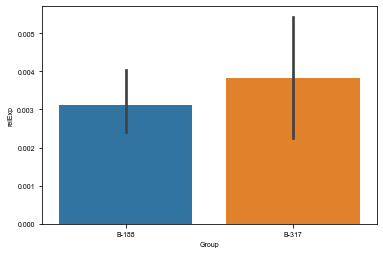

In [35]:
sns.barplot(data=df_sg1, x='Group', y='relExp')

<AxesSubplot:xlabel='Group', ylabel='relExp'>

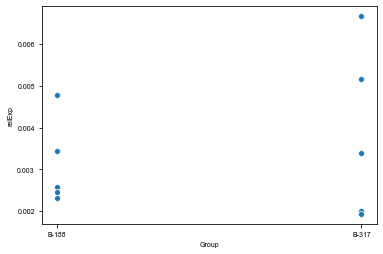

In [36]:
sns.scatterplot(data=df_sg1, x='Group', y='relExp')

In [37]:
df_sg2 = get_expression_data(df, 'Itga9 sg2 v2')

In [38]:
df_sg2

,Sample,Cq_ref,Cq_test,deltaCq,relExp,Group
0,B-188-1,22.296608,35.959532,13.662924,0.000077,B-188
1,B-188-2,19.685096,34.736312,15.051216,0.000029,B-188
2,B-188-3,19.329868,34.833278,15.503410,0.000022,B-188
3,B-188-4,20.838192,34.498038,13.659846,0.000077,B-188
4,B-188-5,20.293072,35.893704,15.600631,0.000020,B-188
5,B-318-1,22.519284,34.588696,12.069412,0.000233,B-318
6,B-318-2,20.849718,34.355151,13.505434,0.000086,B-318
7,B-318-3,20.775141,35.867548,15.092407,0.000029,B-318
8,B-318-4,19.641979,33.940019,14.298040,0.000050,B-318
9,B-318-5,20.237146,35.166236,14.929090,0.000032,B-318


<AxesSubplot:xlabel='Group', ylabel='relExp'>

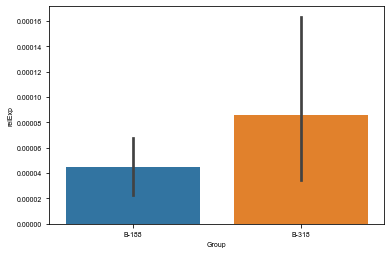

In [39]:
sns.barplot(data=df_sg2, x='Group', y='relExp')

<AxesSubplot:xlabel='Group', ylabel='relExp'>

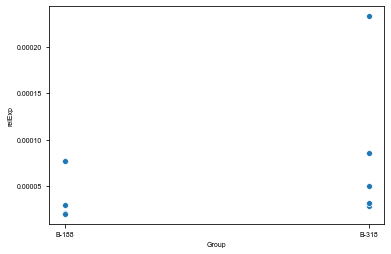

In [40]:
sns.scatterplot(data=df_sg2, x='Group', y='relExp')

In [41]:
df_Itgb1 = get_expression_data(df, 'Itga9 sg3 v2')

<AxesSubplot:xlabel='Group', ylabel='relExp'>

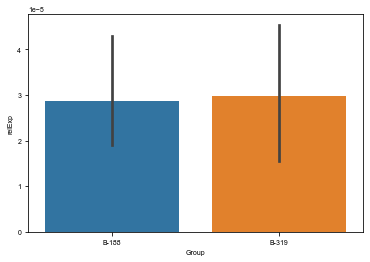

In [42]:
sns.barplot(data=df_Itgb1, x='Group', y='relExp')

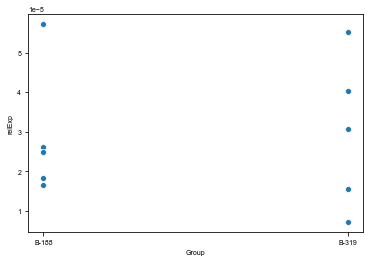

In [44]:
ax=sns.scatterplot(data=df_Itgb1, x='Group', y='relExp')